In [16]:
import pandas as pd

# Load the CSVs into DataFrames
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
store = pd.read_csv('/content/store.csv')

# Show basic info
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Store shape:", store.shape)

# Preview
train.head()


Train shape: (83898, 9)
Test shape: (41088, 8)
Store shape: (1115, 10)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5.0,2015-07-31,5263.0,555.0,1.0,1.0,0,1.0
1,2,5.0,2015-07-31,6064.0,625.0,1.0,1.0,0,1.0
2,3,5.0,2015-07-31,8314.0,821.0,1.0,1.0,0,1.0
3,4,5.0,2015-07-31,13995.0,1498.0,1.0,1.0,0,1.0
4,5,5.0,2015-07-31,4822.0,559.0,1.0,1.0,0,1.0


In [17]:
import pandas as pd

# Load CSVs
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
store = pd.read_csv('/content/store.csv')

# Merge store data into train and test
train = pd.merge(train, store, how='left', on='Store')
test = pd.merge(test, store, how='left', on='Store')

# Convert 'Date' to datetime
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

# Sort values
train = train.sort_values(['Store', 'Date'])

/tmp/ipython-input-17-1703574121.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/content/train.csv')


<Axes: title={'center': 'Store 1 Sales Over Time'}, xlabel='Date'>

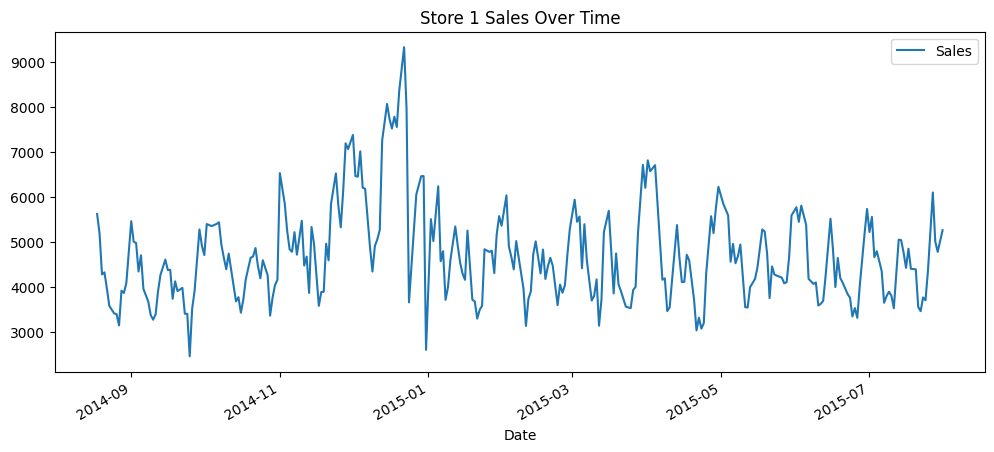

In [18]:
# Filter for Store 1
store_1_sales = train[train['Store'] == 1]

# Drop rows where store was closed (Open=0) or Sales=0
store_1_sales = store_1_sales[(store_1_sales['Open'] == 1) & (store_1_sales['Sales'] > 0)]

# Set index to Date
store_1_sales.set_index('Date', inplace=True)

# View result
store_1_sales[['Sales']].plot(figsize=(12, 5), title='Store 1 Sales Over Time')


<Axes: title={'center': 'Weekly Average Sales - Store 1'}, xlabel='Date'>

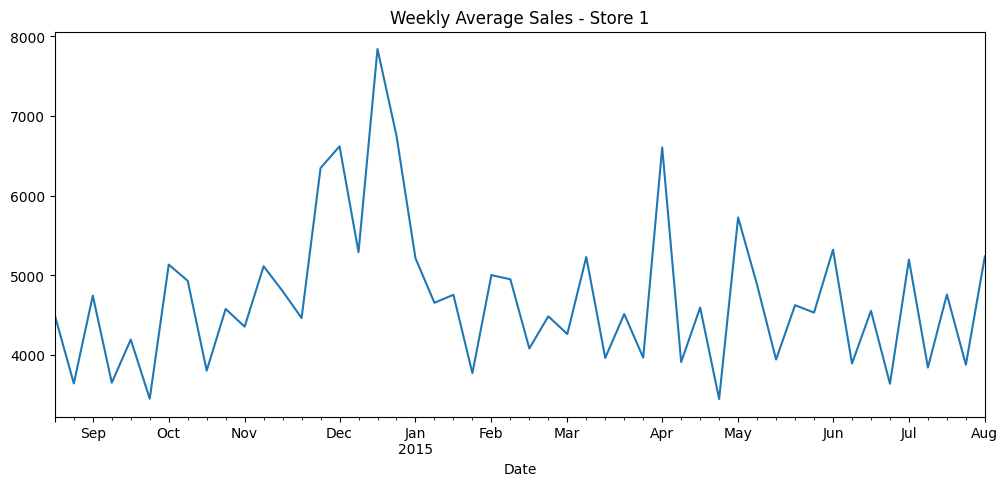

In [19]:
# Resample by week to reduce noise
weekly_sales = store_1_sales['Sales'].resample('W').mean()
weekly_sales.plot(figsize=(12, 5), title='Weekly Average Sales - Store 1')


In [20]:
# Install Prophet
!pip install prophet --quiet

# Import
from prophet import Prophet


In [21]:
# Prophet needs columns: ds (date), y (target)
df_prophet = weekly_sales.reset_index()
df_prophet.columns = ['ds', 'y']
df_prophet.head()


,ds,y
0,2014-08-24,4495.500000
1,2014-08-31,3640.166667
2,2014-09-07,4743.500000
3,2014-09-14,3649.333333
4,2014-09-21,4192.333333


In [22]:
model = Prophet(weekly_seasonality=True, daily_seasonality=False)
model.fit(df_prophet)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1ttbaytn/apqlzyds.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1ttbaytn/is8hp16x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5375', 'data', 'file=/tmp/tmp1ttbaytn/apqlzyds.json', 'init=/tmp/tmp1ttbaytn/is8hp16x.json', 'output', 'file=/tmp/tmp1ttbaytn/prophet_modellrlyg7zd/prophet_model-20250724064615.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:46:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:46:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


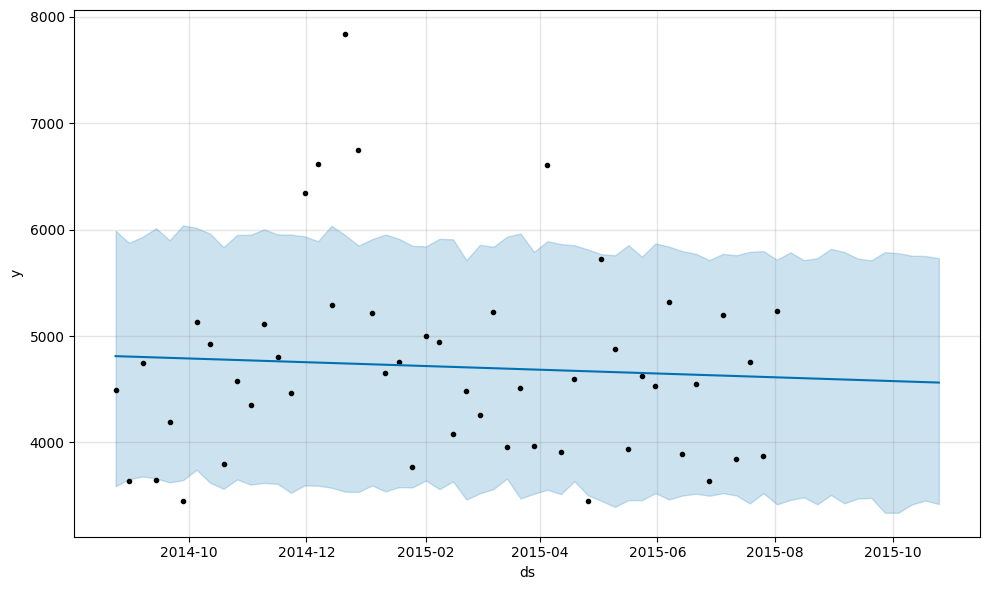

In [23]:
# Forecast for next 12 weeks (approx. 3 months)
future = model.make_future_dataframe(periods=12, freq='W')
forecast = model.predict(future)

# Plot forecast
model.plot(forecast);


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Merge true and predicted values
merged = df_prophet.copy()
merged['yhat'] = forecast['yhat'][:len(df_prophet)].values

mae = mean_absolute_error(merged['y'], merged['yhat'])
rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 670.29
RMSE: 906.87


In [27]:
from prophet.plot import plot_plotly
import plotly.graph_objs as go

# STEP 1: Extend the dataframe into the future (next 30 days)
future = model.make_future_dataframe(periods=30)

# STEP 2: Forecast
forecast = model.predict(future)

# STEP 3: Visualize forecast
fig = plot_plotly(model, forecast)
fig.update_layout(title='Future Sales Forecast for Next 30 Days',
                  xaxis_title='Date',
                  yaxis_title='Sales',
                  width=900,
                  height=500)
fig.show()

# STEP 4: Display only future predictions
future_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)
print(future_forecast)

           ds         yhat   yhat_lower   yhat_upper
50 2015-08-03  -619.589788 -1753.239711   519.668385
51 2015-08-04  -620.170437 -1716.160332   492.867434
52 2015-08-05  -620.749105 -1801.825992   541.352408
53 2015-08-06  -621.337495 -1814.029731   464.959886
54 2015-08-07  -621.919374 -1862.041525   499.606836
55 2015-08-08  -622.501299 -1750.768308   511.745703
56 2015-08-09  4607.530243  3395.264725  5787.480185
57 2015-08-10  -623.676463 -1763.109598   641.429865
58 2015-08-11  -624.257112 -1751.200723   550.908051
59 2015-08-12  -624.835781 -1776.316259   527.688825
60 2015-08-13  -625.424170 -1791.512010   573.768192
61 2015-08-14  -626.006050 -1858.768905   572.850959
62 2015-08-15  -626.587974 -1651.833523   517.581482
63 2015-08-16  4603.443568  3572.953553  5853.322364
64 2015-08-17  -627.763138 -1758.122332   480.581880
65 2015-08-18  -628.343788 -1746.546556   582.706622
66 2015-08-19  -628.922456 -1868.725290   620.269140
67 2015-08-20  -629.510846 -1707.000252   531.

In [28]:
pip install streamlit prophet pandas matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.9 MB/s eta 0:00:00
